# Introduzione <a id="intro"></a>

Il presente progetto è stato sviluppato nell'ambito del corso di Fondamenti di Analisi dei Dati. L'obiettivo principale del progetto è applicare le tecniche e i metodi appresi durante il corso per analizzare un dataset reale, estrapolare informazioni significative, generare intuizioni utili relative alla classificazione. L'analisi si concentrerà su vari aspetti dei dati, tra cui la pulizia e la preparazione dei dati, l'analisi esplorativa...

Il dataset assegnato per questa analisi è l'Internet Advertisement dataset, un insieme di dati che rappresenta un insieme di possibili annunci pubblicitari su pagine Internet. Il compito principale associato a questo dataset è prevedere se un'immagine è un annuncio pubblicitario ("ad") o meno ("nonad").

## Indice:
* [Descrizione del Dataset](#descr-dataset)
* [Caricamento dei dati](#caricamento-dati)
    * [Acquisizione del Dataset](#acquisizione-dataset)
* [Pre-processing dei dati](#pre-processing)
    * [Gestione valori mancanti](#valori-mancanti)
* [Analisi dei dati ](#analisi-dati)
    * [Statistiche Descrittive](#statistiche-descrittive)
    * [Distribuzione dei dati](#distribuzione-dati)
    * [Outliers](#outliers)
* [Bilanciamento del dataset](#bilanciamento-dataset)
* [Riduzione di dimensionalità](#riduzione-dimensionalità)


# Descrizione del Dataset <a id="descr-dataset"></a>

Internet Advertisement Dataset è stato generato tra aprile e luglio 1998. È composto da 3279 istanze, di cui 2821 sono classificate come "nonad" e 458 come "ad". Ogni istanza è descritta da 1558 attributi, di cui 3 continui e il resto binari. Gli attributi continui possono essere mancanti nel 28% delle istanze secondo quanto segnalato nella documentazione. Di seguito si propone uno schema della sua struttura:
* Nome del Dataset: Internet Advertisement Dataset
* Origine: Creato da Nicholas Kushmerick tra aprile e luglio 1998.
* Numero di Istanze: 3279 istanze, suddivise in 2821 "nonad" e 458 "ad".
* Numero di Attributi: 1558 attributi, di cui 3 continui e il resto binari costituiti da variabily dummy, raggruppabili in "url", "origurl", "ancurl", "alt" e "caption".
* Valori Mancanti: Il 28% delle istanze manca di uno o più attributi continui.
* Descrizione degli Attributi: Gli attributi continui codificano la geometria dell'immagine (se disponibile); Gli attributi binari sono relativi alla presenza o meno di frasi che si verificano nell'URL dell'immagine, nell'URL e nel testo alternativo dell'immagine, nel testo dell'ancora e nelle parole che si verificano vicino al testo dell'ancora.

Si noti inoltre che non è presente una suddivisione in train e test set prestabilita dagli autori del dataset. Il dataset viene distribuito secondo la seguente struttura:
* ad.names, qui sono presenti tutti i nomi dei 1558 attributi presenti;
* ad.data, qui sono presenti tutti i 3279 records del dataset;
* ad.DOCUMENTATION: documentazione distribuita insieme al dataset.

# Caricamento dei Dati <a id="caricamento-dati"></a>

## Imports

In [186]:
# Install requirements
%pip install --user -qr ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Acquisizione del Dataset <a id="acquisizione-dataset"></a>

Di seguito si procede ad acquisire il dataset. Si utilizza l'encoding ISO-8859-1 a causa di alcuni caratteri non standard nel file.

In [188]:
with open('ad.names', encoding='ISO-8859-1') as fp:
    cols = []
    for line in fp:
        line = line.strip()
        if line.endswith(': continuous.') or line.endswith(': 0,1.'):
            colname = line.split(':')[0]
            cols.append(colname)
    cols.append('label')

In [189]:
# Viene caricato il dataset utilizzando i nomi delle colonne estratte dal file 'ad.names'
options = {
    'header': None, # il file non ha riga di intestazione
    'names': cols, 
    'skipinitialspace': True, # riumuove eventuali spazi bianchi iniziali
    'low_memory': False}
df = pd.read_csv('ad.data', **options)

In [190]:
# Stampa righe del dataset per osservare la struttura dati
df

height width  aratio local  url*images+buttons  url*likesbooks.com  \
0       125   125     1.0     1                   0                   0   
1        57   468  8.2105     1                   0                   0   
2        33   230  6.9696     1                   0                   0   
3        60   468     7.8     1                   0                   0   
4        60   468     7.8     1                   0                   0   
...     ...   ...     ...   ...                 ...                 ...   
3274    170    94  0.5529     0                   0                   0   
3275    101   140  1.3861     1                   0                   0   
3276     23   120  5.2173     1                   0                   0   
3277      ?     ?       ?     1                   0                   0   
3278     40    40     1.0     1                   0                   0   

      url*www.slake.com  url*hydrogeologist  url*oso  url*media  \
0                     0                   0        0          0   
1                     0                   0        0          0   
2                     0                   0        0          0   
3                     0                   0        0          0   
4                     0                   0        0          0   
...                 ...                 ...      ...        ...   
3274                  0                   0        0          0   
3275                  0                   0        0          0   
3276                  0                   0        0          0   
3277                  0                   0        0          0   
3278                  0                   0        0          0   

      url*peace+images  url*blipverts  url*tkaine+kats  url*labyrinth  \
0                    0              0                0              0   
1                    0              0                0              0   
2                    0              0                0              0   
3                    0              0                0              0   
4                    0              0                0              0   
...                ...            ...              ...            ...   
3274                 0              0                0              0   
3275                 0              0                0              0   
3276                 0              0                0              0   
3277                 0              0                0              0   
3278                 0              0                0              0   

      url*advertising+blipverts  url*images+oso  url*area51+corridor  \
0                             0               0                    0   
1                             0               0                    0   
2                             0               0                    0   
3                             0               0                    0   
4                             0               0                    0   
...                         ...             ...                  ...   
3274                          0               0                    0   
3275                          0               0                    0   
3276                          0               0                    0   
3277                          0               0                    0   
3278                          0               0                    0   

      url*ran+gifs  url*express-scripts.com  url*off  url*cnet  url*time+1998  \
0                0                        0        0         0              0   
1                0                        0        0         0              0   
2                0                        0        0         0              0   
3                0                        0        0         0              0   
4                0                        0        0         0              0   
...            ...                      ...      ...       ...         

In [191]:
df.dtypes

height                object
width                 object
aratio                object
local                 object
url*images+buttons     int64
                       ...  
caption*here           int64
caption*click          int64
caption*for            int64
caption*you            int64
label                 object
Length: 1559, dtype: object

I valori mancanti vengono indicati con '?' nel dataset, per cui per essere elaborati con pandas, vengono sostituiti con nan.

In [192]:
columns_with_question_mark = (df == "?").any()
columns_with_question_mark[columns_with_question_mark].index

Index(['height', 'width', 'aratio', 'local'], dtype='object')

In [193]:
df = df.replace('?', np.nan)

Viene impostato il tipo corretto per le feature che presentavano valori mancanti

In [194]:
df['height'] = df['height'].astype(float)
df['width'] = df['width'].astype(float)
df['aratio'] = df['aratio'].astype(float)
df['local'] = df['local'].astype(float)

# Pre-processing dei dati <a id="pre-processing"></a>

## Mappatura labels

La variabile categorica label è un object, ma è una variabile binaria, dunque si decide di cambiare il type da object ad int con:
* 0 = nonad.
* 1 = ad.

In [195]:
df['label'] = df['label'].map({'nonad.': 0, 'ad.': 1}).astype(int)

## Split train e test set

In [196]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [197]:
print(train_set.shape)
print(test_set.shape)

(2623, 1559)
(656, 1559)


## Gestione valori mancanti <a id="valori-mancanti"></a>

### Test Set

Per il test set, si procede all'eliminazione dei records con valori mancanti.

In [198]:
test_set.isna().sum()

height                184
width                 184
aratio                186
local                   3
url*images+buttons      0
                     ... 
caption*here            0
caption*click           0
caption*for             0
caption*you             0
label                   0
Length: 1559, dtype: int64

In [199]:
test_set.dropna(inplace=True)

In [200]:
test_set.isna().sum()

height                0
width                 0
aratio                0
local                 0
url*images+buttons    0
                     ..
caption*here          0
caption*click         0
caption*for           0
caption*you           0
label                 0
Length: 1559, dtype: int64

In [223]:
test_set['local'] = test_set['local'].astype(int)
test_set.shape

(467, 1559)

### Train Set

Verifica dei valori mancanti come indicato dalla documentazione

In [203]:
train_set.isna().sum()

height                719
width                 717
aratio                724
local                  12
url*images+buttons      0
                     ... 
caption*here            0
caption*click           0
caption*for             0
caption*you             0
label                   0
Length: 1559, dtype: int64

In [204]:
columns_with_missing_values = train_set.isna().sum() > 0
columns_with_missing_values[columns_with_missing_values]

height    True
width     True
aratio    True
local     True
dtype: bool

Come ci si aspettava rispetto alla documentazione, il dataset presenta diversi dati mancanti, di seguito il totale dei record affetti:

In [205]:
missing_data_rows = (train_set.isna().sum(axis=1) > 0).sum()
print(missing_data_rows)
print(str(round(missing_data_rows * 100 / train_set.shape[0], 2)) + "%")

731
27.87%


#### Height, Width, Aratio

In [206]:
print(round(train_set.loc[1, 'width'] / train_set.loc[1, 'height'], 4), train_set.loc[1, 'aratio'])

8.2105 8.2105


Considerato che:
* I valori mancanti si concentrano nelle features `Height`, `Width`, `Arazio`;
* `arazio = width/height`

ci si occuperà di gestire i valori mancanti in height e width per poi ricavare arazio da essi.

Di seguito il numero di records con le features height, width, aratio con dati mancanti:

In [207]:
(train_set[['height', 'width', 'aratio']].isna().any(axis=1)).sum()

724

Metodi per la loro gestione:

* **Eliminazione diretta delle colonne**: Come si nota, le features principalmente affette sono quelle con dati continui relative alle immagini. Una soluzione potrebbe essere l'eliminazione di `height`, `width` e `aratio`.

* **Eliminazione records**: Eliminare direttamente le righe con dati mancanti. Soluzione indicata per poche righe con dati mancanti, in questo caso si andrebbero ad eliminare 910 records, ovvero 27.75% del totale.

* **Imputazione con la media o mediana**: avendo grossa parte dei valori mancanti, la media stimata potrebbe discostarsi di molto da quella effettiva;

* **Imputazione con moda**: viene mantenuta l'indipendenza delle osservazioni (le adv sono indipendenti per ogni record), non ha bisogno di ordinamenti, di contro si potrebbe sovrastimare la frequenza di caratteristiche comuni.

* **Imputazione KNN**: Le osservazioni sono considerate come punti nello spazio delle features e i valori mancanti sono stimati sulla base dei k vicini più prossimi.


Si è deciso di procedere con l'imputazione della moda per height e width e ricavare da essa aratio.

In [208]:
height_mode = train_set['height'].mode()[0]
width_mode = train_set['width'].mode()[0]

# Imputo i valori mancanti
train_set['height'].fillna(height_mode, inplace=True)
train_set['width'].fillna(width_mode, inplace=True)
train_set['aratio'].fillna(width_mode/height_mode, inplace=True)

#### Local

Di seguito i records con la feature local con dati mancanti:

In [209]:
(train_set[['local']].isna().any(axis=1)).sum()

12

Considerando che sono solo 15 i record con local indefinito, per cui lo 0.45% del totale, si procede all'eliminazione di questi records.

In [210]:
train_set = train_set.dropna(subset=['local'])
train_set['local'] = train_set['local'].astype(int)

Osservazione dati puliti

In [211]:
train_set.isna().sum()

height                0
width                 0
aratio                0
local                 0
url*images+buttons    0
                     ..
caption*here          0
caption*click         0
caption*for           0
caption*you           0
label                 0
Length: 1559, dtype: int64

# Analisi dei dati <a id="analisi-dati"></a>

Dalla prima revisione è emerso che visualizzare i dati è possibile facilmente solo per le variabili continue, meno per le variabili dummy. Provare a fare un conteggio degli 1 e zero per ogni variabile per capire quanto sparso è il dataset.

## Statistiche Descrittive <a id="statistiche-descrittive"></a>

In [224]:
pd.set_option('display.max_columns', None)
train_set.describe(include='all')

height        width       aratio        local  url*images+buttons  \
count  2611.000000  2611.000000  2611.000000  2611.000000         2611.000000   
mean     62.596323   239.290693     4.926099     0.771352            0.004213   
std      47.397886   177.487901     5.051376     0.420042            0.064783   
min       1.000000     1.000000     0.001500     0.000000            0.000000   
25%      32.000000    90.000000     1.296400     1.000000            0.000000   
50%      60.000000   150.000000     4.500000     1.000000            0.000000   
75%      60.000000   468.000000     7.800000     1.000000            0.000000   
max     640.000000   640.000000    60.000000     1.000000            1.000000   

       url*likesbooks.com  url*www.slake.com  url*hydrogeologist      url*oso  \
count         2611.000000        2611.000000         2611.000000  2611.000000   
mean             0.012256           0.004979            0.003064     0.003447   
std              0.110047           0.070399            0.055279     0.058621   
min              0.000000           0.000000            0.000000     0.000000   
25%              0.000000           0.000000            0.000000     0.000000   
50%              0.000000           0.000000            0.000000     0.000000   
75%              0.000000           0.000000            0.000000     0.000000   
max              1.000000           1.000000            1.000000     1.000000   

         url*media  url*peace+images  url*blipverts  url*tkaine+kats  \
count  2611.000000       2611.000000    2611.000000      2611.000000   
mean      0.011107          0.003447       0.003064         0.008809   
std       0.104822          0.058621       0.055279         0.093459   
min       0.000000          0.000000       0.000000         0.000000   
25%       0.000000          0.000000       0.000000         0.000000   
50%       0.000000          0.000000       0.000000         0.000000   
75%       0.000000          0.000000       0.000000         0.000000   
max       1.000000          1.000000       1.000000         1.000000   

       url*labyrinth  url*advertising+blipverts  url*images+oso  \
count    2611.000000                2611.000000     2611.000000   
mean        0.005362                   0.003064        0.003447   
std         0.073043                   0.055279        0.058621   
min         0.000000                   0.000000        0.000000   
25%         0.000000                   0.000000        0.000000   
50%         0.000000                   0.000000        0.000000   
75%         0.000000                   0.000000        0.000000   
max         1.000000                   1.000000        1.000000   

       url*area51+corridor  url*ran+gifs  url*express-scripts.com     url*off  \
count          2611.000000   2611.000000              2611.000000  2611.00000   
mean              0.005362      0.003064                 0.005745     0.00383   
std               0.073043      0.055279                 0.075592     0.06178   
min               0.000000      0.000000                 0.000000     0.00000   
25%               0.000000      0.000000                 0.000000     0.00000   
50%               0.000000      0.000000                 0.000000     0.00000   
75%               0.000000      0.000000                 0.000000     0.00000   
max               1.000000      1.000000                 1.000000     1.00000   

          url*cnet  url*time+1998  url*josefina3  url*truluck.com  \
count  2611.000000    2611.000000    2611.000000      2611.000000   
mean      0.002681       0.004213       0.004213         0.005362   
std       0.051718       0.064783       0.064783         0.073043   
min       0.000000       0.000000       0.000000         0.000000   
25%       0.000000       0.000000       0.000000         0.000000   
50%       0.000000       0.000000       0.000000         0.000000   
75%       0.000000       0.000000       0.000000         0.000000   
max       1.00000

Principali considerazioni:
* **height e width**: media width (241.20) è molto superiore media height (62.93), con std maggiore nella dimensione orizzontale rispetto a quella verticale.
* **aratio**: Il valore medio è 4.99, indicando che l'ampiezza è mediamente circa cinque volte l'altezza. Std elevata.
* **local**: Colonna binaria con un valore medio di 0.76, suggerendo che la maggior parte dei valori assunti è 1.
* La quasi totalità delle variabili categoriche binarie ha una media molto piccola in valore, suggerendo che la maggior parte dei valori assume 0, dunque il dataset risulta sparso.

 ## Distribuzione dei dati <a id="distribuzione-dati"></a>

### Distribuzione delle classi

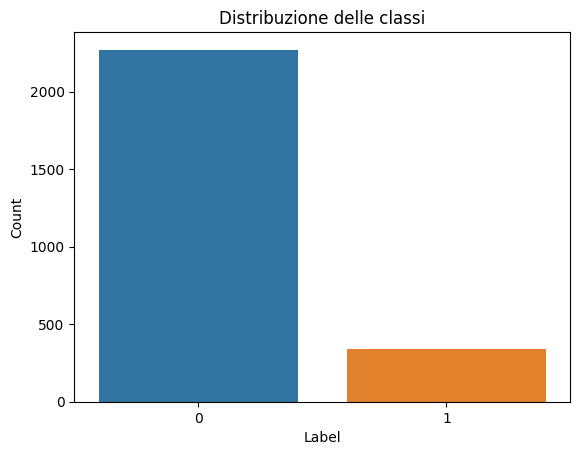

In [227]:
sns.countplot(data=train_set, x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribuzione delle classi')
plt.show()

Come si può apprezzare, il dataset risulta fortemente sbilanciato verso le label "nonad.", ottenendo molti meno campioni per "ad.". In una sezione successiva si valuteranno tecniche di bilanciamento del dataset.

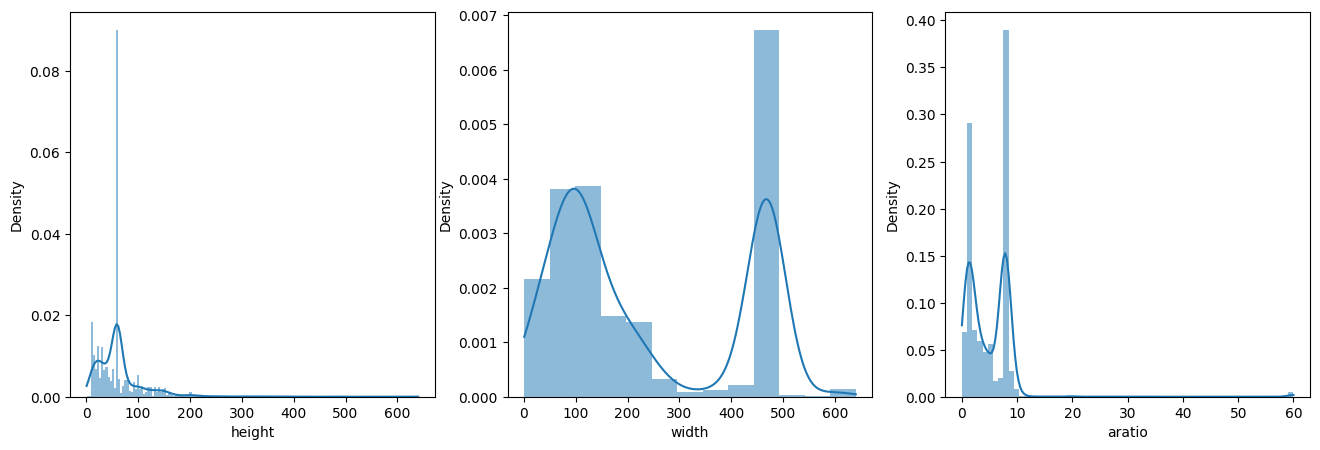

In [228]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(16)

sns.histplot(train_set['height'], kde=True, stat="density", linewidth=0, ax=ax[0])
sns.histplot(train_set['width'], kde=True, stat="density", linewidth=0, ax=ax[1])
sns.histplot(train_set['aratio'], kde=True, stat="density", linewidth=0, ax=ax[2])

plt.show()

Si nota in parte una positive skew per le variabili continue

<Axes: >

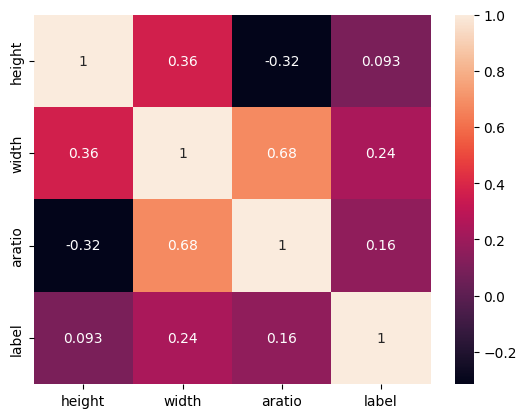

In [229]:
sns.heatmap(train_set.iloc[:,[0,1,2,1558]].corr(method="spearman"),annot=True)

Si può notare una buona correlazione (Pearson) tra le variabili continue inerenti alle immagini.

In [230]:
# Raggruppa le variabili dummy in cluster
url_features = train_set[[col for col in train_set.columns if col.startswith('url*')]]
origurl_features = train_set.filter(like='origurl*')
ancurl_features = train_set.filter(like='ancurl*')
alt_features = train_set.filter(like='alt*')
caption_features = train_set.filter(like='caption*')

# Lista dei cluster e corrispondenti nomi dei cluster
clusters = [url_features, origurl_features, ancurl_features, alt_features, caption_features]
cluster_names = ['url', 'origurl', 'ancurl', 'alt', 'caption']

# Creazione della figura interattiva con sottoplot per ogni cluster
fig = make_subplots(rows=len(clusters), cols=1, subplot_titles=cluster_names)

# Aggiunta dei grafici a barre interattivi per ogni cluster
for i, cluster in enumerate(clusters):
    counts = cluster.sum()
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, hovertemplate="Label: %{x}<br>Occorrenze di 1: %{y}"), row=i+1, col=1)

# Aggiunta dei titoli e impostazioni del layout
fig.update_layout(height=500*len(clusters), title_text="Numero di occorrenze di 1 per cluster di variabili dummy")
fig.update_xaxes(tickangle=45, tickfont=dict(size=8), showgrid=False)
fig.update_yaxes(title_text="Numero di occorrenze di 1")

fig.show()


Come si può osservare, il dataset risulta molto sparso, poche variabili superano il 4% dei records nel numero di occorrenze.

## Outliers <a id="outliers"></a>

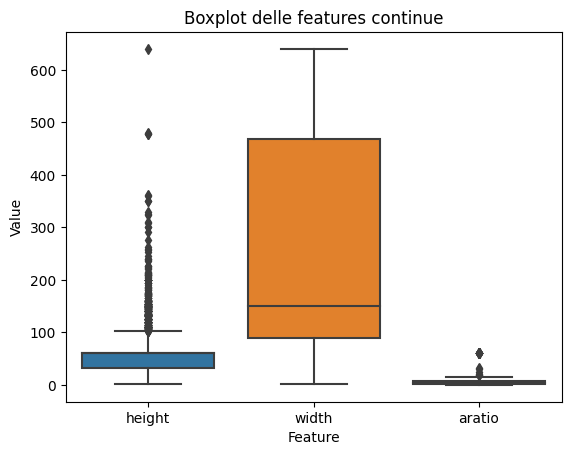

In [232]:
sns.boxplot(data=train_set.iloc[:, :3])
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Boxplot delle features continue')
plt.show()

Vengono valutati gli outlier per le variabili continue: la prima componente presenta possibili outlier che andrebbero indagati, comunque i valori rientrano nell'intorno di width.

# Riduzione di dimensionalità <a id="riduzione-dimensionalità"></a>

PCA in clusters? Url, origurl, ancurl, alt e caption

In [220]:
def show_pca_var_plot(pca, cluster_title):
    explained_variance = pca.explained_variance_ratio_
    print(len(explained_variance))
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5,
            align='center', label=cluster_title + ' individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

457 495 472 111 19
47


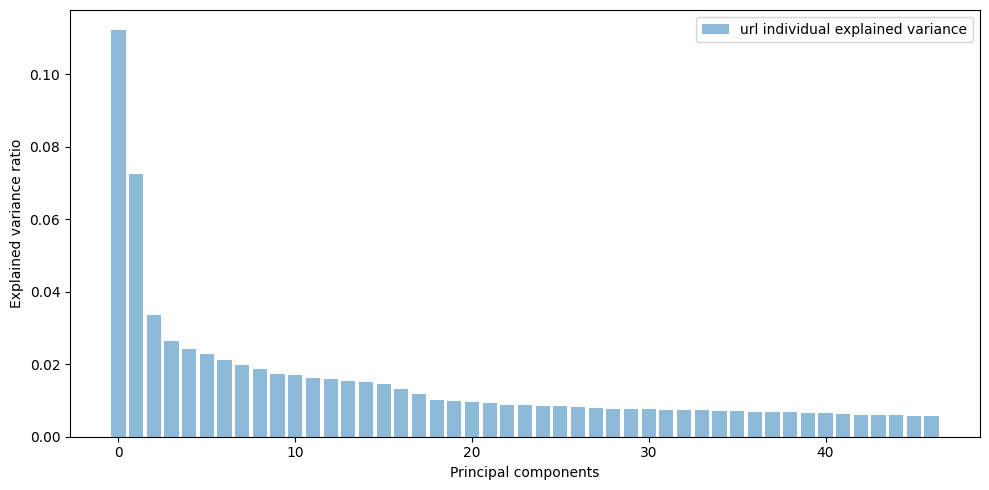

44


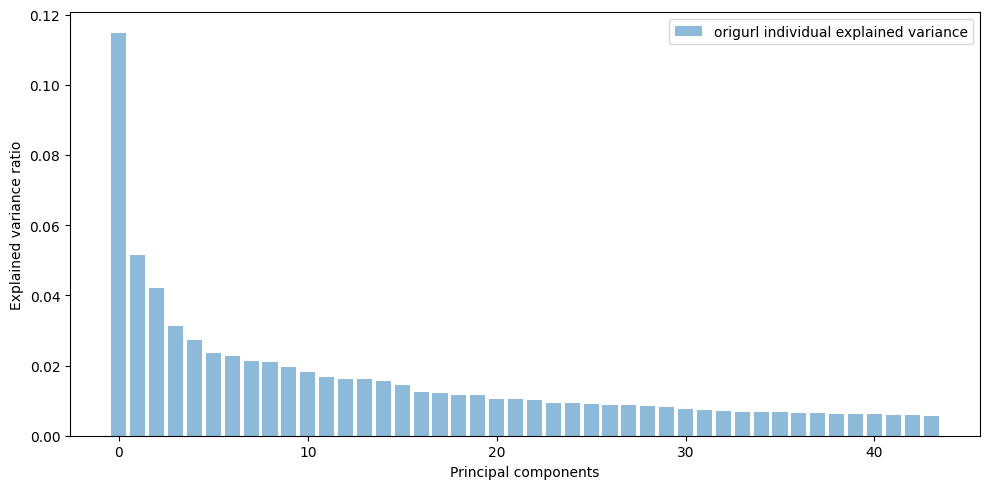

35


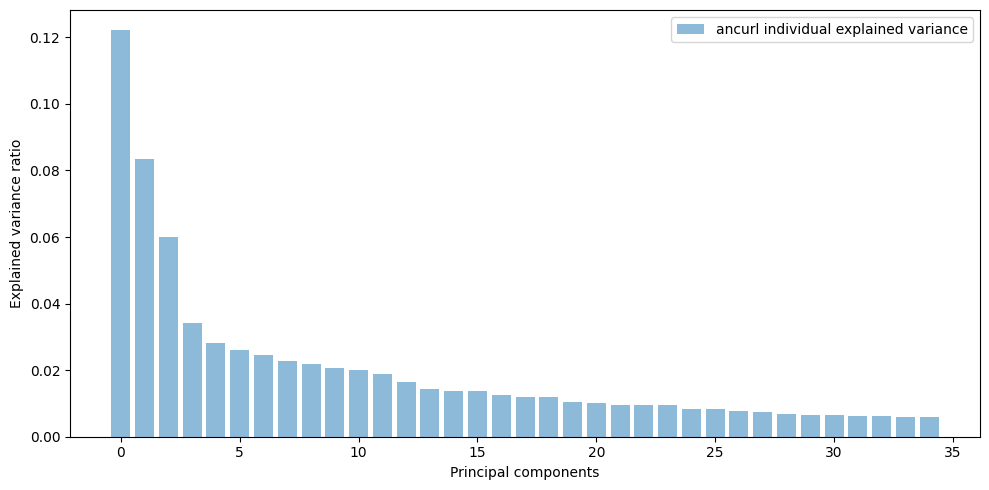

27


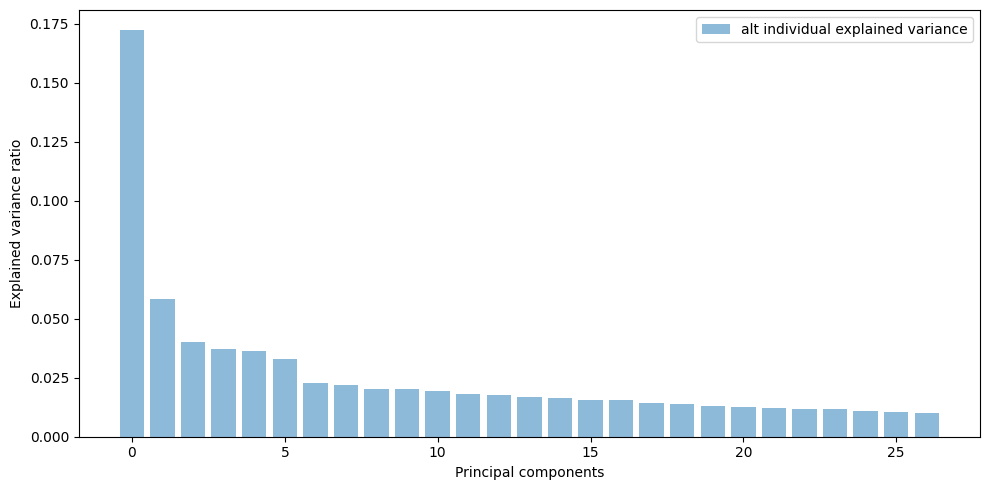

5


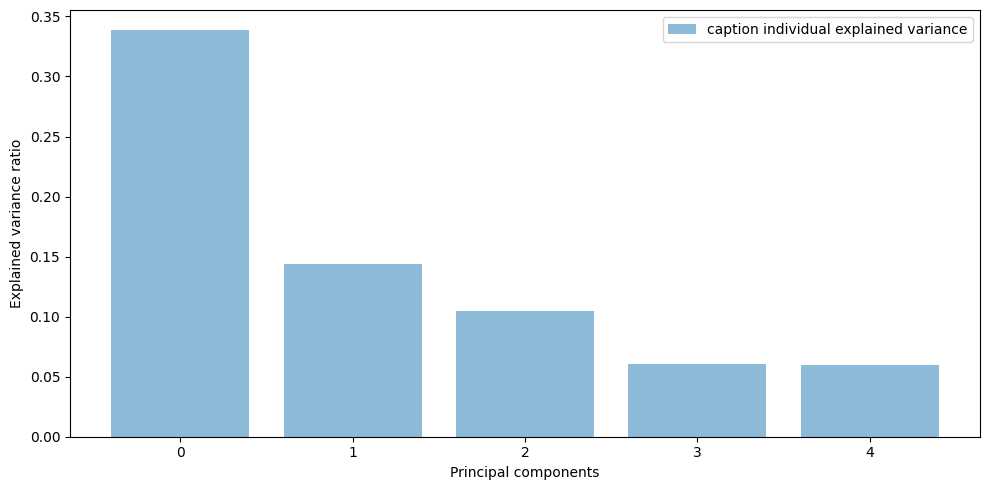

In [221]:
# Separating out the feature clusters
url_features = df[[col for col in df.columns if col.startswith('url*')]]
origurl_features = df.filter(like='origurl*')
ancurl_features = df.filter(like='ancurl*')
alt_features = df.filter(like='alt*')
caption_features = df.filter(like='caption*')
print(url_features.shape[1], origurl_features.shape[1], ancurl_features.shape[1], alt_features.shape[1], caption_features.shape[1])

# Applying PCA
pca = PCA(n_components=0.70) # Keep 95% of variance
url_pca = pca.fit_transform(url_features)
show_pca_var_plot(pca, "url")
origurl_pca = pca.fit_transform(origurl_features)
show_pca_var_plot(pca, "origurl")
ancurl_pca = pca.fit_transform(ancurl_features)
show_pca_var_plot(pca, "ancurl")
alt_pca = pca.fit_transform(alt_features)
show_pca_var_plot(pca, "alt")
caption_pca = pca.fit_transform(caption_features)
show_pca_var_plot(pca, "caption")
# ...

# Concatenating the PCA-transformed feature clusters back together
final_features = np.concatenate((url_pca, origurl_pca, ancurl_pca, alt_pca, caption_pca), axis=1)


Grafico a barre che mostra quanta varianza è spiegata da ciascuna componente principale.

# Bilanciamento del dataset <a id="bilanciamento-dataset"></a>

Prima o dopo PCA?  Dopo

Prima o dopo split in train e test set? Una buona pratica consiste nel separare i dati sintetici da quelli reali e utilizzare i primi solo in fase di training. Si dovrebbe fare dopo dunque. fare smote solo sul train

SMOTE

# Futuro

dopo:  Regression, Support Vector Classifier, KNN classifier, 
prima e dopo: Random Forest
Classifier prima e dopo

plot x variabili contare gli 1 in x

contare varianza feature